<a href="https://colab.research.google.com/github/LeoTU911/SCC413/blob/main/CycleGAN_3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install dominate
!pip install visdom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 47.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 8.6 MB/s eta 0:00:00
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408217 sha256=b26dd14b643f2b1391dd33a2c3edfcbae9dfb08cf326a896b3e626bfef52b899
  Stored in directory: /root/.cache/pip/wheels/fb/b1/fc/b05c2c1930a412f01bd07dacaeb5fd8cc4bcccf71c835b0281
Successfully built visdom


In [3]:
import dominate
import visdom
import os

In [4]:
!git clone https://github.com/LeoTU911/SCC413/

Cloning into 'SCC413'...
remote: Enumerating objects: 751, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 751 (delta 7), reused 12 (delta 3), pack-reused 732
Receiving objects: 100% (751/751), 63.80 MiB | 18.06 MiB/s, done.
Resolving deltas: 100% (109/109), done.


In [5]:
cd /content/SCC413/CycleGAN

/content/SCC413/CycleGAN


In [6]:
!python train.py\
  --dataroot ./datasets/CUHK/\
  --name      s2p_cyclegan\
  --model     cycle_gan\
  --batch_size   8\
  --netD      n_layers\
  --n_layers_D   5\
  --n_epochs    10\
  --n_epochs_decay 10\
  --norm      batch\
  --netG      unet_256

----------------- Options ---------------
               batch_size: 8                             	[default: 1]
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ./datasets/CUHK/              	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
 

In [7]:
!python test.py --dataroot ./datasets/CUHK/ --name s2p_cyclegan --model cycle_gan --netD n_layers --n_layers_D 5 --norm batch --netG unet_256

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ./datasets/CUHK/              	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                            

In [37]:
import difflib
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import skimage
import cv2

def getCorrespondingRealImage(fileName, img_List):
  keywords = fileName.split('_')
  label_tmp = keywords[2].split('.')
  label = 'real_' + label_tmp[0]

  relatedImages = difflib.get_close_matches(keywords[0], img_List, 6, 0.3)
  realImage = difflib.get_close_matches(label, relatedImages, 1, 0.3)

  return realImage[0]

def imgPredictionEvaluate(realImg, predictImg):
  realImg = skimage.io.imread(realImg)
  predictImg = skimage.io.imread(predictImg)
  realImg_gray = cv2.cvtColor(realImg, cv2.COLOR_BGR2GRAY)
  predictImg_gray = cv2.cvtColor(predictImg, cv2.COLOR_BGR2GRAY)

  img_array_real  = img_as_float(realImg_gray)
  img_array_predict = img_as_float(predictImg_gray)

  mse_2img = mean_squared_error(img_array_real, img_array_predict)
  ssim_2img = ssim(img_array_real, img_array_predict,
                    data_range=img_array_predict.max() - img_array_predict.min())

  evaluations = [round(mse_2img, 4), round(ssim_2img, 4)]
  return evaluations


In [38]:
result_Path = './results/s2p_cyclegan/test_latest/images'
img_List = list(sorted(os.listdir(result_Path)))
img_Results = []

for fileName in img_List:
  img_tmp = os.path.join(result_Path, fileName)

  img_real_name = getCorrespondingRealImage(fileName, img_List)
  img_real = os.path.join(result_Path, img_real_name)
  evaluation_tmp = imgPredictionEvaluate(img_real, img_tmp)

  img_Results.append([img_tmp, evaluation_tmp])

True

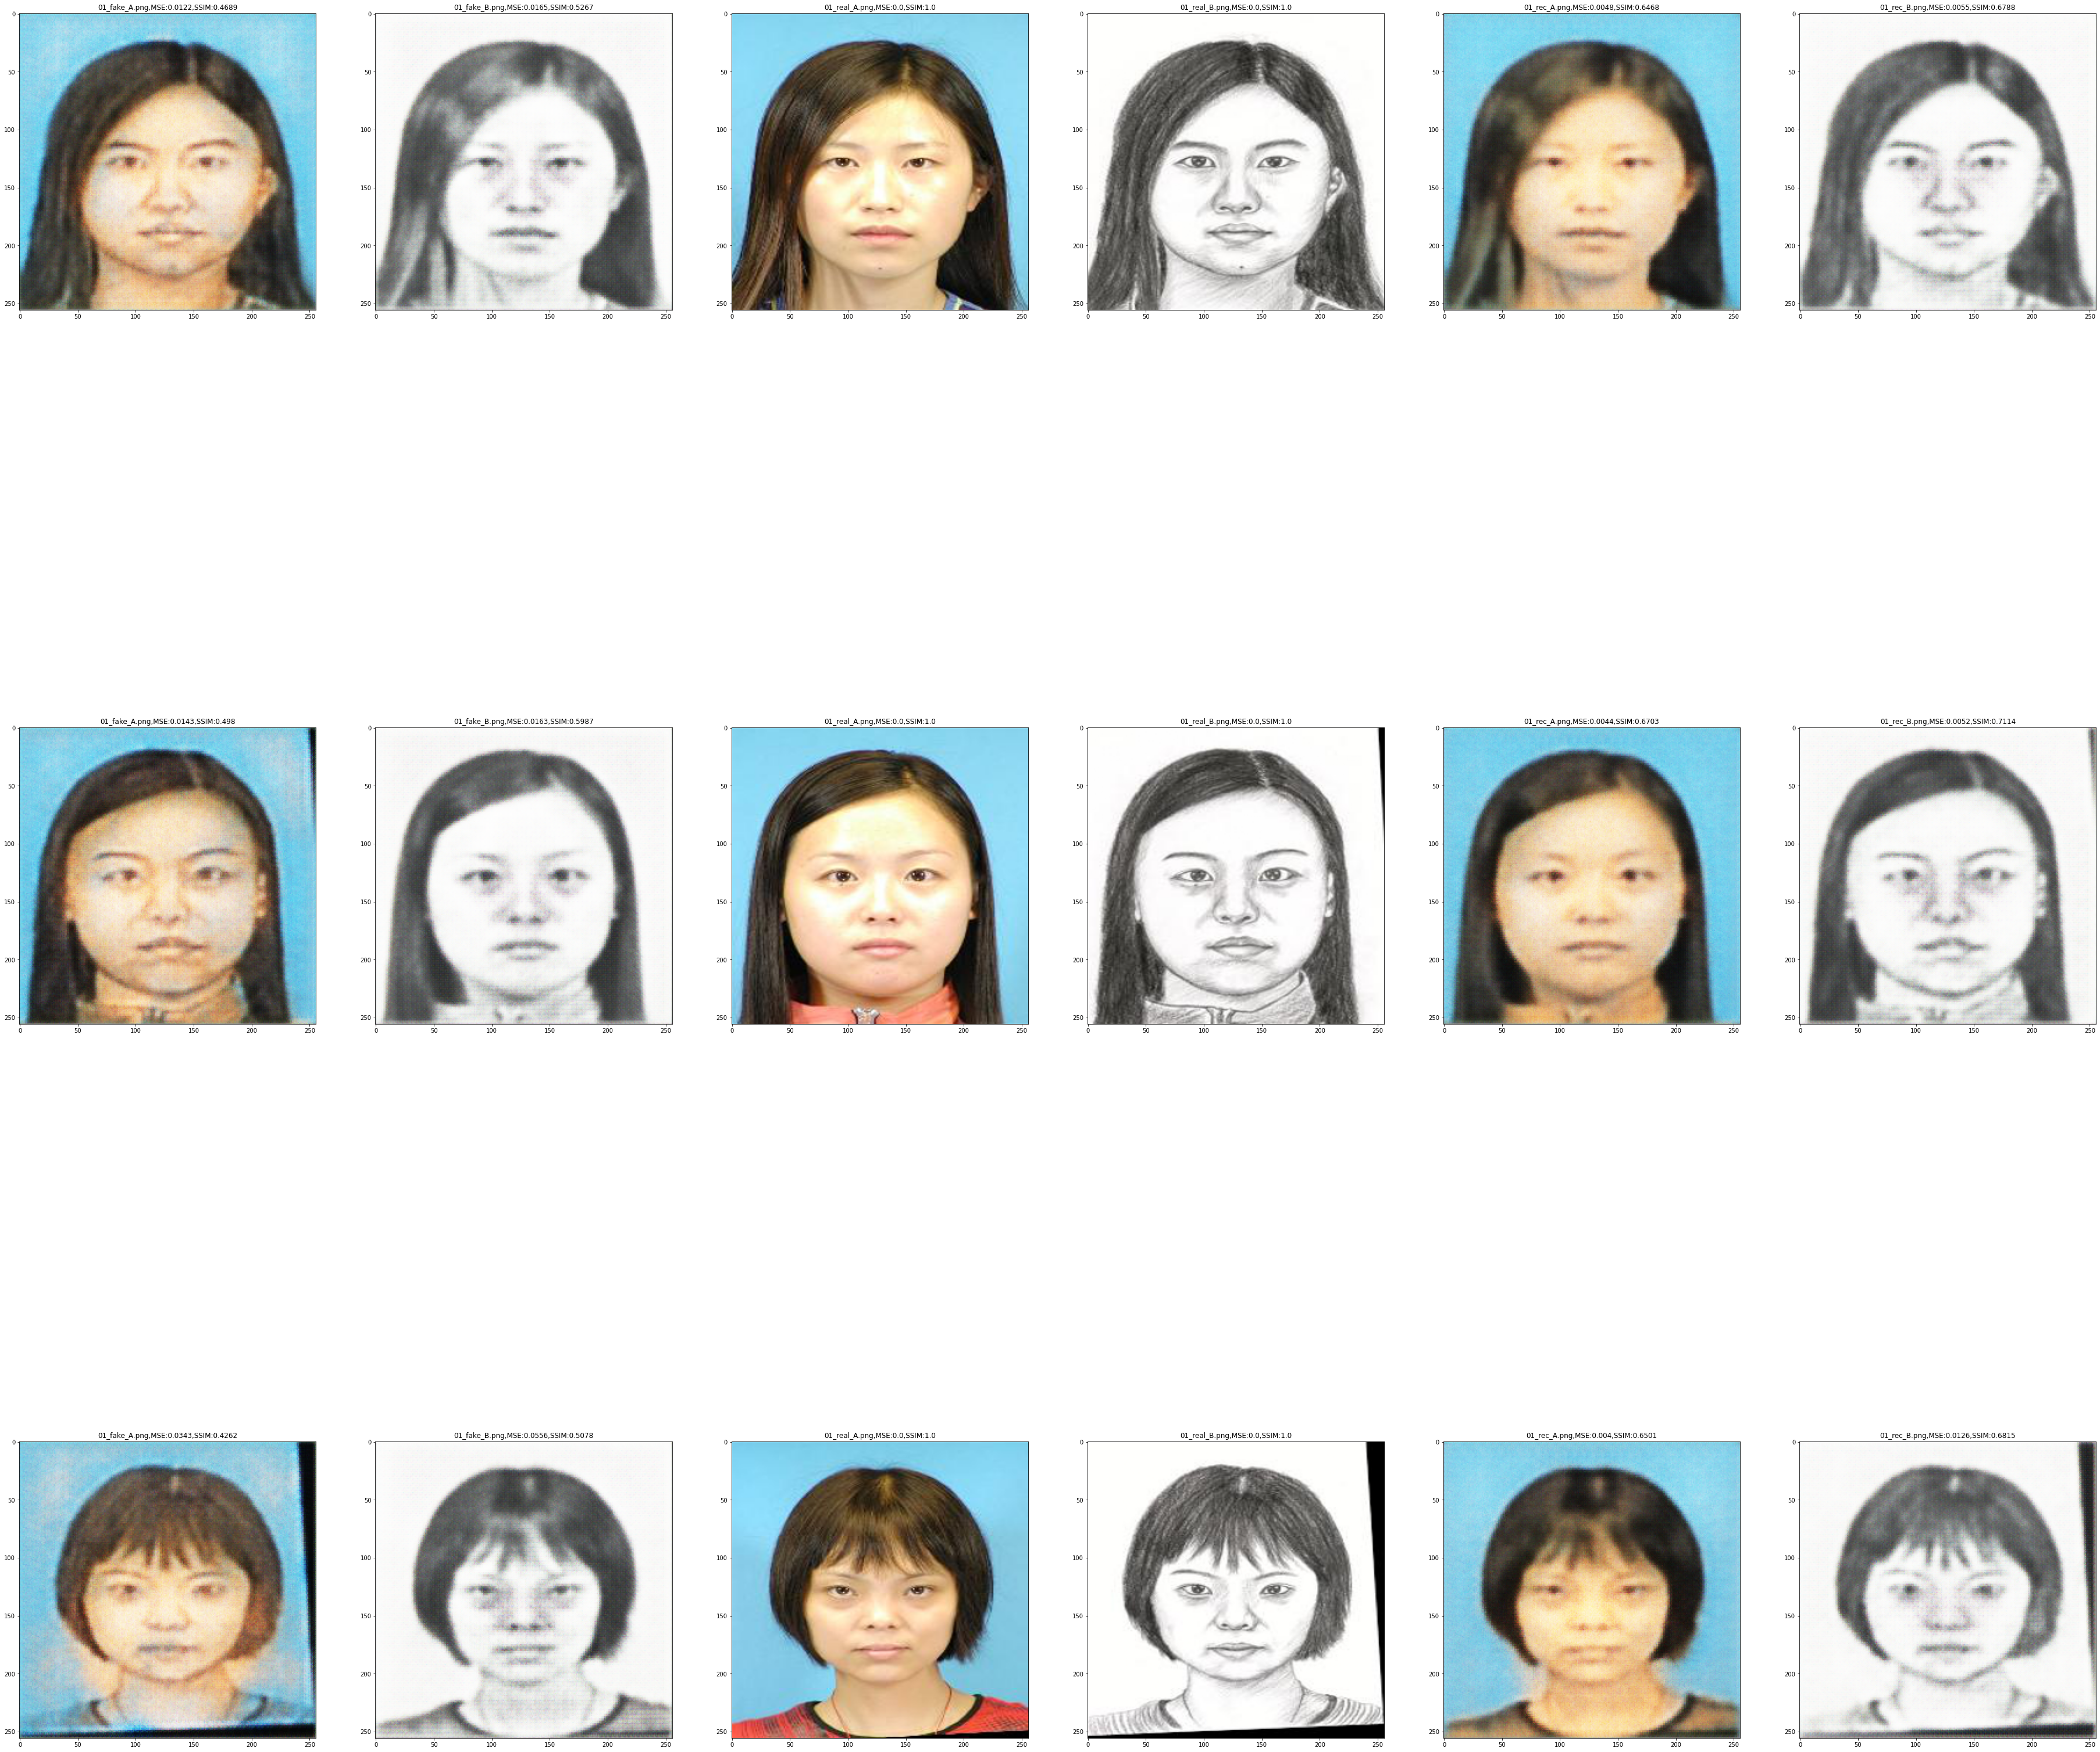

In [41]:
import matplotlib.pyplot as plt

def plotPredictImages(n_images):
  plt.figure(figsize = (64, 64))
  for i in range(1,n_images+1):
    check = n_images%6
    if check == 0:
      rows = n_images//6
    else:
      rows = n_images//6 + 1

    plt.subplot(rows,6,i)
    img = plt.imread(img_Results[i-1][0])

    name_tmp = img_List[i-1].split('-')
    name = name_tmp[2]
    mse = img_Results[i-1][1][0]
    ssim = img_Results[i-1][1][1]

    title = '{},MSE:{},SSIM:{}'.format(name, mse, ssim) 
    plt.title(title)
    plt.imshow(img)
  return True

plotPredictImages(18)
